In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

C:\Users\nived\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with h5py.File("mnist_traindata.hdf5", 'r') as hf:
    xdata = hf['xdata'][:]
    ydata = hf['ydata'][:]

print("Dimension of xdata",np.shape(xdata))
print("Dimension of ydata",np.shape(ydata))

Dimension of xdata (60000, 784)
Dimension of ydata (60000, 10)


In [3]:
train_data,val_data,train_label,val_label = train_test_split(xdata,ydata,test_size = 1.0/6.0)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(train_label))
print(np.shape(val_label))

(50000, 784)
(10000, 784)
(50000, 10)
(10000, 10)


In [4]:
with h5py.File("mnist_testdata.hdf5", 'r') as hf:
    test_data = hf['xdata'][:]
    test_label = hf['ydata'][:]

print("Dimension of test data",np.shape(test_data))
print("Dimension of test label",np.shape(test_label))

Dimension of test data (10000, 784)
Dimension of test label (10000, 10)


In [5]:
class my_MLP():
    def __init__(self,hls, act, lr,ep,bch_size,l_reg):
        Weight = []
        bias=[]
        for h in range(0,len(hls)-1):
#             w=np.sqrt(1/hls[h])*np.random.randn(hls[h+1],hls[h]) #Glorot
            w= np.sqrt(2/(hls[h+1]+hls[h]))*np.random.randn(hls[h+1],hls[h]) #He normalization
#             w= np.random.uniform(-1,1,(hls[h+1],hls[h]))
            b= np.random.uniform(-1,1,hls[h+1])
            Weight.append(w)
            bias.append(b)
        if(act == 'relu'):
            activ = 0
        else:
            activ =1
        self.W = Weight
        self.b= bias
        self.activation= activ
        self.eta= lr
        self.epoch=ep
        self.batch_size = bch_size
        self.lam_reg = l_reg
    
    def Activation_fn(self,x):
        if self.activation==0:
            return max(0,x)
        else:
            return np.tanh(x)
        
    def Activation_der_fn(self,x):
        if self.activation==0:
            if(x>0):
                return 1
            elif(x<0):
                return 0
            else:
                return np.random.uniform(0,1)
        else:
            return 1-(np.tanh(x))**2

    def Softmax(self,xvector):
        xdim = len(xvector)
        xden = 0
        for i in range(0,xdim):
            xi =  np.exp(xvector[i])
            xden = xi+xden
            xvector[i] =xi
        xvector = xvector/xden
        return xvector  
    
    def forward_network(self,W,b,xdata):         
        hidden_layer = np.matmul(W,xdata)
        hidden_layer =hidden_layer+b
        for i in range(0,len(hidden_layer)):
            hidden_layer[i] = self.Activation_fn(hidden_layer[i])  
        return hidden_layer
    
    def backward_network(self,W,b,xdata):
        hidden_layer = np.matmul(W,xdata)
        hidden_layer =hidden_layer+b
        for i in range(len(hidden_layer)):
            hidden_layer[i] = self.Activation_der_fn(hidden_layer[i])  
        return hidden_layer
    
    def error_check(self,output_layer,ydata):
        ndim = len(output_layer)   
        maxval = -1
        for j in range(ndim):
            if(output_layer[j]>maxval):
                maxval = output_layer[j]
                maxind = j
        for j in range(ndim):
            if(maxind==j):
                if ydata[j]!=1:
                    return False
            else:
                if ydata[j]!=0:
                    return False
        return True
    
    
    def MLP_pred(self,dataset,datalabel):
        w_len = len(self.W)
        sum_error=0
        for i in range(0,len(dataset)):
            xdata = dataset[i,:]
            ydata = datalabel[i,:]
            output_layer = np.copy(xdata)
            for j in range(w_len):
                if(j==w_len-1):
                        output_layer = np.matmul(self.W[j],output_layer)
                        output_layer = output_layer+self.b[j]
                        output_layer = self.Softmax(output_layer) 
                else:
                    output_layer =self.forward_network(self.W[j],self.b[j],output_layer)
                    
            bool_val = self.error_check(output_layer,ydata)
            if(bool_val==True):
                sum_error+=1
        accuracy = sum_error/len(dataset)
        return accuracy
    
    def file_save(self,filename):
        w_len = len(self.W)
        with h5py.File(filename, 'w') as hf:
            for i in range(w_len):
                hf.create_dataset('b'+str(i+1), data = self.b[i])
            for i in range(w_len):
                hf.create_dataset('w'+str(i+1), data = self.W[i])
            hf.attrs['act'] = np.string_("relu")
        
    
    def MLP_fit(self,train_data,train_label,val_data,val_label): 
        learning_rates = []
        w_len = len(self.W)
        train_acc = []
#         val_acc = []
        del_w = []
        del_b = []
        epochs = []
        for j in range(0,w_len): 
            weight_curr = self.W[j]
            del_w.append(np.zeros((len(weight_curr),len(weight_curr[0,:]))))
            del_b.append(np.zeros(len(weight_curr)))
        for ep in range(1,self.epoch+1):
            epochs.append(ep)
            if ep == 2*(self.epoch//5) or ep==4*(self.epoch//5):
                self.eta = self.eta/2
                learning_rates.append(ep)
            
            for i in range(0,len(train_data)):
                xdata = train_data[i,:]
                ydata = train_label[i,:]
                output_layer = np.copy(xdata)
                A_list = []
                Ader_list = []
                for j in range(0,w_len):
                    if(j==w_len-1):
                            output_layer = np.matmul(self.W[j],output_layer)
                            output_layer = output_layer+self.b[j]
                            output_layer = self.Softmax(output_layer) 
                    else:
                        Ader_list.append(self.backward_network(self.W[j],self.b[j],output_layer))
                        output_layer =self.forward_network(self.W[j],self.b[j],output_layer)
                    A_list.append(output_layer)

                for j in range(0,w_len):
                    j_rev = w_len-1-j
                    if(j==0):
                        delta_l = A_list[j_rev] - ydata
                    else:
                        delta_l = np.matmul(np.transpose(self.W[j_rev+1]),delta_l)*Ader_list[j_rev]
                    if(j_rev==0):
                        del_w[j_rev] = del_w[j_rev]+ np.outer(delta_l,xdata)
                    else:
                        del_w[j_rev] = del_w[j_rev]+ np.outer(delta_l,A_list[j_rev-1])
                    del_b[j_rev] = del_b[j_rev]+ delta_l
                if((i+1)%self.batch_size==0):
                    for j in range(0,w_len):
                        self.W[j] = (1-2*self.eta*self.lam_reg)*self.W[j] - (self.eta/float(self.batch_size))*del_w[j]
                        self.b[j] = self.b[j] - (self.eta/float(self.batch_size))*del_b[j]
                        del_w[j] = 0.0*del_w[j]
                        del_b[j]= 0.0* del_b[j]

            train_accuracy = self.MLP_pred(train_data,train_label)
#             val_accuracy = self.MLP_pred(val_data,val_label)
            
            train_acc.append(train_accuracy)
#             val_acc.append(val_accuracy)
            print("Epoch: ",ep,". Train Accuracy is: ",train_accuracy)#," Validation accuracy is: ",val_accuracy)
        plt.figure()
        plt.plot(epochs,train_acc)
#         plt.plot(epochs,val_acc)
        plt.axvline(x= learning_rates[0],linestyle = "--")
        plt.axvline(x= learning_rates[1],linestyle="--")
        plt.ylabel('Accuracy', color='k')
        plt.xlabel('Number of epochs')
#         plt.legend(('Accuracy of train data','Accuracy of Validation data'), loc='best')
        plt.show()

Epoch:  1 . Train Accuracy is:  0.894
Epoch:  2 . Train Accuracy is:  0.9177666666666666
Epoch:  3 . Train Accuracy is:  0.9326333333333333
Epoch:  4 . Train Accuracy is:  0.94165
Epoch:  5 . Train Accuracy is:  0.9477833333333333
Epoch:  6 . Train Accuracy is:  0.9528
Epoch:  7 . Train Accuracy is:  0.9570833333333333
Epoch:  8 . Train Accuracy is:  0.9599166666666666
Epoch:  9 . Train Accuracy is:  0.9623
Epoch:  10 . Train Accuracy is:  0.9644
Epoch:  11 . Train Accuracy is:  0.9662333333333334
Epoch:  12 . Train Accuracy is:  0.9673666666666667
Epoch:  13 . Train Accuracy is:  0.9686333333333333
Epoch:  14 . Train Accuracy is:  0.9698
Epoch:  15 . Train Accuracy is:  0.9704833333333334
Epoch:  16 . Train Accuracy is:  0.9715333333333334
Epoch:  17 . Train Accuracy is:  0.9720666666666666
Epoch:  18 . Train Accuracy is:  0.97275
Epoch:  19 . Train Accuracy is:  0.9731833333333333
Epoch:  20 . Train Accuracy is:  0.9765166666666667
Epoch:  21 . Train Accuracy is:  0.9770333333333333


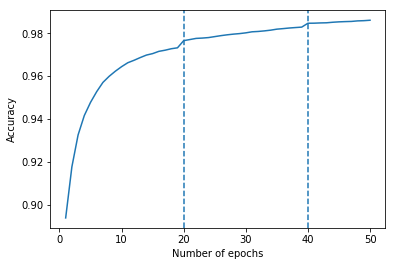

Test Accuracy:  0.9688


In [6]:
model =my_MLP([784,30,20,10], 'relu', 0.1,50,200,0.0)
model.MLP_fit(xdata,ydata,val_data,val_label)
model.file_save("suresh_nivedita_hw3_2.hdf5")
test_acc = model.MLP_pred(test_data,test_label)
print("Test Accuracy: ",test_acc)
